In [1]:
import csv
import numpy as np
from os import path

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

from tqdm import tqdm

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
# [id, vocab_limit, min_word_freq, window_size, epochs, batch_size, embedding_dim, learning_rate] 
hyperparams = dict([(1, ['1', 15000, 5, 5, 1, 50, 100, 0.01]), 
                   (2, ['2', 20000, 5, 5, 30, 50, 200, 0.01]), 
                   (3, ['3', 30000, 10, 5, 50, 50, 200, 0.01])])
hparam = hyperparams[1]

Corpus Size: 11448 sentences, 371700 words, 15000 unique words


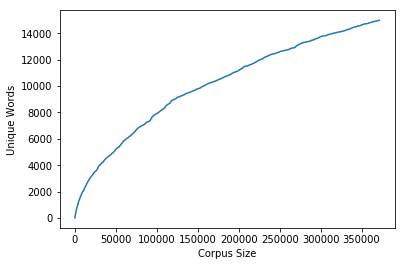

In [3]:
corpus_file = 'corpus.txt'
vocab_limit = hparam[1]

def load_corpus(file_name, vocab_limit):
    with open(file_name, 'r', encoding='utf-8') as f:
        corpus, vocab = [], {}
        corpus_size = vocab_size = 0
        x, y = [0], [0]
        
        for line in f:
            line = line.strip().split(' ')
            for w in line:
                if w.strip() != '':
                    if w in vocab:
                        vocab[w] += 1
                    else:
                        vocab[w] = 1
                        vocab_size += 1
            corpus.append(line)
            corpus_size += len(line)
            x.append(corpus_size)
            y.append(vocab_size)
            if vocab_size >= vocab_limit:
                break
        
        print('Corpus Size: %d sentences, %d words, %d unique words' % (len(corpus), corpus_size, vocab_size))
        plt.plot(x, y)
        plt.xlabel('Corpus Size')
        plt.ylabel('Unique Words')
        plt.show()
        return corpus, vocab, corpus_size

corpus, vocab, corpus_size = load_corpus(corpus_file, vocab_limit)

In [4]:
# Histogram for word frequencies
lst=list(vocab.values())
lst.sort()

#lst with word frequency less than equal to 5
x=[i for i in lst if i<=5]
print(len(x))

#lst with word frequency greater than equal to 100
y=[i for i in lst if i>=100]
print(len(y))

#lst with word frequency greater than equal to 100
z=[i for i in lst if i<100 and i>5]
print(len(z))

10290
505
4205


14495


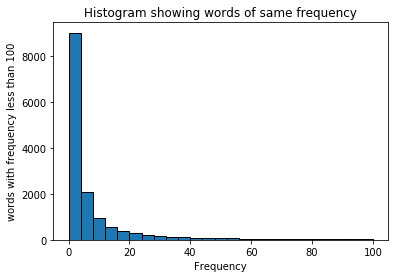

In [5]:
newLst=[i for i in lst if i<100]
print(len(newLst))

plt.xlabel('Frequency')
plt.ylabel('words with frequency less than 100')
plt.title('Histogram showing words of same frequency')
plt.hist(newLst,bins=range(0,101,4),edgecolor='black')
plt.show()

In [6]:
min_word_freq = hparam[2]

def process_vocab(vocab, min_freq):
    wid = 0
    word2id = {}
    id2word = {}
    id2freq = {}
    for w, f in vocab.items():
        if f < min_freq:
            continue    
        word2id[w] = wid
        id2word[wid] = w
        id2freq[wid] = f
        wid += 1
        
    print('Trimmed Vocabulary Size: %d words, %d frequency total' % (len(word2id), sum(id2freq.values())))
    return word2id, id2word, id2freq

word2id, id2word, id2freq = process_vocab(vocab, min_word_freq)


Trimmed Vocabulary Size: 5271 words, 348353 frequency total


4766


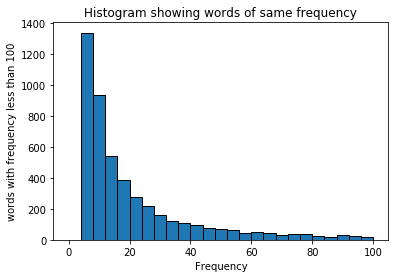

In [7]:
#Histogram showing words with frequency greater than 5
lst1=list(id2freq.values())
lst1.sort()
#lst=lst[:-200]
newLst1=[i for i in lst1 if i<100]
print(len(newLst1))
plt.xlabel('Frequency')
plt.ylabel('words with frequency less than 100')
plt.title('Histogram showing words of same frequency')
plt.hist(newLst1,bins=range(0,101,4),edgecolor='black')
plt.show()

In [8]:
window_size = hparam[3]

def process_corpus(corpus, word2id, window_size):
    tcorpus = []
    tcorpus_size = 0
    for sentence in corpus:
        s = []
        for word in sentence:
            if word in word2id:
                s.append(word2id[word])
        if s != []:
            tcorpus_size += len(s)
            tcorpus.append(s)
    
    corpus_pairs = []
    for sentence in tcorpus:
        for i, u in enumerate(sentence):
            for j, v in enumerate(sentence):
                if j != i and j >= i - window_size and j < i + window_size:
                    corpus_pairs.append((u, v))
                
    print('Trimmed Corpus Size: %d words, %d sentences' % (tcorpus_size, len(tcorpus)))
    print('Total Number of Pairs: %d' % len(corpus_pairs))
    return tcorpus, corpus_pairs

tcorpus, corpus_pairs = process_corpus(corpus, word2id, window_size)

Trimmed Corpus Size: 348353 words, 11442 sentences
Total Number of Pairs: 2850050


In [9]:
np.random.seed(12345)

sample_table = []
sample_table_size = 1e8
pow_frequency = np.array(list(id2freq.values()))**0.75
words_pow = sum(pow_frequency)
ratio = pow_frequency / words_pow
count = np.round(ratio * sample_table_size)
for wid, c in enumerate(count):
    sample_table += [wid] * int(c)
sample_table = np.array(sample_table)

def get_neg_v_neg_sampling(batch, count, sample_table):
    neg_v = np.random.choice(sample_table, size=(len(batch), count)).tolist()
    return neg_v

In [10]:
class SkipGramModel(nn.Module):
    def __init__(self, emb_size, emb_dimension):
        super().__init__()
        self.emb_size = emb_size
        self.emb_dimension = emb_dimension
        self.u_embeddings = nn.Embedding(emb_size, emb_dimension, sparse=True)
        self.v_embeddings = nn.Embedding(emb_size, emb_dimension, sparse=True)
        self.init_emb()
        
    def init_emb(self):
        initrange = 0.5 / self.emb_dimension
        self.u_embeddings.weight.data.uniform_(-initrange, initrange)
        self.v_embeddings.weight.data.uniform_(-0, 0)

    def forward(self, pos_u, pos_v, neg_v):
        emb_u = self.u_embeddings(pos_u)
        emb_v = self.v_embeddings(pos_v)
        score = torch.mul(emb_u, emb_v).squeeze()
        score = torch.sum(score, dim=1)
        score = F.logsigmoid(score)
        neg_emb_v = self.v_embeddings(neg_v)
        neg_score = torch.bmm(neg_emb_v, emb_u.unsqueeze(2)).squeeze()
        neg_score = F.logsigmoid(-1 * neg_score)
        return -1 * (torch.sum(score)+torch.sum(neg_score))

In [11]:
sg_model_file = 'sgmodel-' + hparam[0] + '.pt'
epochs = hparam[4]
batch_size = hparam[5]
embedding_dim = hparam[6]
embedding_size = len(word2id)
learning_rate = hparam[7]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Current Device: ', device)

sg_model = SkipGramModel(embedding_size, embedding_dim).to(device)
optimizer = optim.SGD(sg_model.parameters(), lr=learning_rate)

epoch = -1
if path.exists(sg_model_file):
    checkpoint = torch.load(sg_model_file)
    sg_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    
    print(epoch)
    print(loss.item())
    
    sg_model.train()

Current Device:  cpu
24
109.14774322509766


In [15]:
batch_count = len(corpus_pairs) // batch_size
progress_bar = tqdm(range(batch_count * (epoch + 1), batch_count * epochs))

losses = []
for i in progress_bar:
    batch_start = (i % batch_count) * batch_size
    batch = corpus_pairs[batch_start: batch_start + batch_size]

    batch_u = np.array([pair[0] for pair in batch])
    batch_v = np.array([pair[1] for pair in batch])
    neg_v = np.array(get_neg_v_neg_sampling(batch, 5, sample_table))
    
    batch_u = torch.from_numpy(batch_u).to(device)
    batch_v = torch.from_numpy(batch_v).to(device)
    neg_v = torch.from_numpy(neg_v).to(device)
        
    optimizer.zero_grad()
    loss = sg_model.forward(batch_u, batch_v, neg_v)
    loss.backward()
    optimizer.step()

    l = loss.item()
    losses.append((i // batch_count, i % batch_count, l))
    
    if i % 1000 == 0:
        progress_bar.set_description("Loss: %0.8f, lr: %0.6f" % 
                                 (l, optimizer.param_groups[0]['lr']))

#     if i * batch_size % 100000 == 0:
#         lr = initial_lr * (1.0 - 1.0 * i / total_batch_count)
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = lr

    if (i % batch_count == batch_count - 1):
        print(i, i // batch_count)
        torch.save({
            'epoch': i // batch_count,
            'model_state_dict': sg_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, sg_model_file)

0it [00:00, ?it/s]


In [16]:
embedding_file = 'embedding-' + hparam[0] + '.txt'
loss_file = 'loss-' + hparam[0] + '.txt'

def save_output(model, id2word, embeddding_file, loss_file,losses):
    embedding = model.u_embeddings.weight.data.numpy()

    with open(embedding_file, 'w', encoding='utf-8') as f:
        f.write('%d %d\n' % (embedding.shape[0], embedding.shape[1]))
        for wid, w in id2word.items():
            e = embedding[wid]
            e = ' '.join(map(lambda x: str(x), e))
            f.write('%s %s\n' % (w, e))

    with open(loss_file, 'a+') as f:
        for loss in losses:
            f.write('%d, %d, %0.2f\n' % loss)
            
save_output(sg_model, id2word, embedding_file, loss_file, losses)

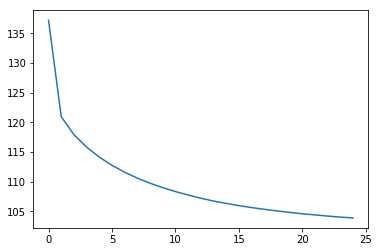

In [17]:
def plot_loss(loss_file):
    losses = []
    with open(loss_file, 'r') as f:
        for line in f:
            line = line.split(', ')
            losses.append((int(line[0]), int(line[1]), float(line[2])))

    y = []
    for i in range(losses[-1][0] + 1):
        yi = [x[2] for x in losses if x[0] == i]
        y.append(sum(yi) / (losses[-1][1] + 1))
    plt.plot(y)
    plt.show()

plot_loss(loss_file)

In [18]:
from bidi.algorithm import get_display
import arabic_reshaper
fontFile = "Sahel.ttf"
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname = fontFile).get_name()    
rc('font', family = font_name)

c:\program files\python35\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['Sahel'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


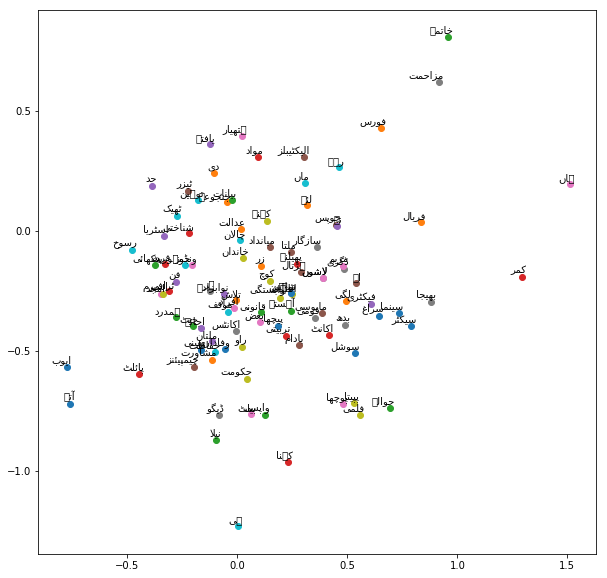

In [19]:
plt.figure(figsize=(10,10))
embedding = sg_model.u_embeddings.weight.data.numpy()
indices = np.random.choice(np.arange(len(word2id)), size=100, replace=True)

for ind in indices:
    word = id2word[ind]
    a=word2id[word]
    vec = embedding[a]
    x, y = vec[0], vec[1]
    plt.scatter(x, y)
    reshaped_text = arabic_reshaper.reshape(word)
    artext = get_display(reshaped_text)
    plt.annotate(artext, xy=(x, y), xytext=(5, 2),textcoords='offset points', ha='right', va='bottom')
    
plt.show()

In [21]:
!pip install keras

Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\program files\\python35\\Lib\\site-packages\\h5py'
Consider using the `--user` option or check the permissions.



In [ ]:
from keras.callbacks import LambdaCallback
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras.utils.data_utils import get_file

In [ ]:
pretrained_weights = sg_model.u_embeddings.weight
print(pretrained_weights.shape)
print(pretrained_weights)

In [ ]:
max_sentence_length = max([len(s) for s in tcorpus])
print(max_sentence_length)

train_x = np.zeros([len(tcorpus), max_sentence_length], dtype=np.int32)
train_y = np.zeros([len(tcorpus)], dtype=np.int32)
for i, sentence in enumerate(tcorpus):
    for t, wid in enumerate(sentence[:-1]):
        train_x[i, t] = wid
    train_y[i] = sentence[-1]
print('train_x shape:', train_x.shape)
print('train_y shape:', train_y.shape)
print(train_x)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=embedding_size, output_dim=embedding_dim, weights=[pretrained_weights.detach().numpy()]))
model.add(LSTM(units=embedding_dim))
model.add(Dense(units=embedding_size))
model.add(Activation('softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [ ]:
def sample(preds, temperature=1.0):
    if temperature <= 0:
        return np.argmax(preds)
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate_next(text, num_generated=10):
    word_idxs = [word2id[word] for word in text.lower().split()]
    for i in range(num_generated):
        prediction = model.predict(x=np.array(word_idxs))
        idx = sample(prediction[-1], temperature=0.7)
        word_idxs.append(idx)
    return ' '.join(id2word[idx] for idx in word_idxs)

def on_epoch_end(epoch, _):
    print('\nGenerating text after epoch: %d' % epoch)
    texts = [
        'غیر ملکی خبر رساں ایجنسی',
        'ہلاک ہونے والوں کی تعداد',
    ]
    for text in texts:
        sample = generate_next(text)
        print('%s... -> %s' % (text, sample))


In [ ]:
model.fit(train_x, train_y,
          batch_size=128,
          epochs=20,
          callbacks=[LambdaCallback(on_epoch_end=on_epoch_end)])

In [ ]:
while True:
  name = input("Enter here:")
  #print(name)
  print(generate_next(name,1))